# EDREAMS-TEST

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tqdm import tqdm
from datetime import datetime
import csv
import pandas as pd
import os
from IPython import embed
import lightgbm as lgb

In [ ]:
main_path = '/Users/paulagomezduran/Desktop/EDREAMS/'
dataset_train = os.path.join(main_path, 'train.csv')
dataset_test = os.path.join(main_path, 'test.csv') 
best_results =  True # FLAG TO ACTIVATE THE PARTS OF THE NOTEBOOK WHICH LEADS FOR BETTER RESULTS

The challenge is to predict whether a customer will ask for an EXTRA_BAGGAGE or not. Thus, the labels for this problem will be the column 'EXTRA_BAGGAGE' of the following dataframe.

## PRE-PROCESSING DATA

In [3]:
df = pd.read_csv(dataset_train, sep=';', engine='python')
print(df.head())

   ID TIMESTAMP WEBSITE  GDS  DEPARTURE    ARRIVAL  ADULTS  CHILDREN  INFANTS  \
0   0   01/July    EDES    1    22/July    25/July       1         0        0   
1   1   01/July    EDIT    0    29/July    29/July       1         0        0   
2   2   01/July    OPUK    2    29/July  19/August       1         0        0   
3   3   01/July    OPIT    0    24/July  04/August       1         0        0   
4   4   01/July    EDES    0  11/August  11/August       1         0        0   

   TRAIN    HAUL_TYPE DISTANCE      DEVICE          TRIP_TYPE PRODUCT    SMS  \
0  False     DOMESTIC  628,844      TABLET         ROUND_TRIP    TRIP   True   
1  False  CONTINENTAL  1281,43  SMARTPHONE            ONE_WAY    TRIP  False   
2  False  CONTINENTAL  1730,35      TABLET         ROUND_TRIP    TRIP   True   
3  False     DOMESTIC  652,702  SMARTPHONE  MULTI_DESTINATION    TRIP  False   
4  False  CONTINENTAL  1717,85    COMPUTER            ONE_WAY    TRIP  False   

   EXTRA_BAGGAGE  NO_GDS  
0    

First, let's take a look at how the classes are balanced for our dataset.

In [4]:
df['EXTRA_BAGGAGE'].value_counts()

False    40201
True      9799
Name: EXTRA_BAGGAGE, dtype: int64

Based on the previous information, where we conclude that most of the passangers have not taken an EXTRA_BAGGAGE, we will focus on telling which features are relevant or which are not before addressing the problem of balancing the classes.

As the TIMESTAMP parameter of this 50k data refers to just to the 1st or the 2nd of July (probably because they are a set of samples collected during those 2 days), they are not relevant for the EXTRA_BAGGAGE prediction task.

ID column is also not adding information as it is just an identifier for each booking.

In [5]:
group_data = df.groupby(['EXTRA_BAGGAGE','TIMESTAMP']).size()
print(group_data)

EXTRA_BAGGAGE  TIMESTAMP
False          01/July      30435
               02/July       9766
True           01/July       7387
               02/July       2412
dtype: int64


In [6]:
print(len(df) == len(np.unique(df['ID'])))

True


I define the next function in order to explore the trip duration instead of ARRIVAL and DEPARTURE dates separately. In the next cell, I run the function on the dataframe. Thus, I will remove ARRIVAL and DEPARTURE columns from the dataframe.

Besides, I will leverage the function to remove TIMESTAMP and ID columns as well, as they won't be useful for us in this case.

In [7]:
def create_tripDuration(df, df_set):

    for i, d in tqdm(enumerate(df['ARRIVAL']), desc=f"Converting ARRIVAL str to datetime [{df_set}]",
                     total=len(df['ARRIVAL'])):
        df['ARRIVAL'][i] = datetime.strptime(d, '%d/%B')
        #df.loc['ARRIVAL', i] = datetime.strptime(d, '%d/%B')

    for i, d in tqdm(enumerate(df['DEPARTURE']), desc=f"Converting DEPARTURE str to datetime [{df_set}]",
                     total=len(df['DEPARTURE'])):
        df['DEPARTURE'][i] = datetime.strptime(d, '%d/%B')
        #df.loc['DEPARTURE', i] = datetime.strptime(d, '%d/%B')

    df['TRIP_DURATION'] = df['ARRIVAL'].sub(df['DEPARTURE'], axis=0).dt.days
    neg_values = df[df['TRIP_DURATION'] < 0]['TRIP_DURATION'] + 365
    df.update(neg_values)
    return df.drop(columns=['DEPARTURE', 'ARRIVAL', 'TIMESTAMP', 'ID'])

In [8]:
df = create_tripDuration(df, 'training set')


Converting ARRIVAL str to datetime [training set]:   0%|          | 0/50000 [00:00<?, ?it/s]/Users/paulagomezduran/Workspace/virtualenvs/research/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
Converting ARRIVAL str to datetime [training set]: 100%|██████████| 50000/50000 [00:13<00:00, 3797.96it/s]
Converting DEPARTURE str to datetime [training set]:   0%|          | 0/50000 [00:00<?, ?it/s]/Users/paulagomezduran/Workspace/virtualenvs/research/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sy

In [9]:
print(df.head())

  WEBSITE  GDS  ADULTS  CHILDREN  INFANTS  TRAIN    HAUL_TYPE DISTANCE  \
0    EDES    1       1         0        0  False     DOMESTIC  628,844   
1    EDIT    0       1         0        0  False  CONTINENTAL  1281,43   
2    OPUK    2       1         0        0  False  CONTINENTAL  1730,35   
3    OPIT    0       1         0        0  False     DOMESTIC  652,702   
4    EDES    0       1         0        0  False  CONTINENTAL  1717,85   

       DEVICE          TRIP_TYPE PRODUCT    SMS  EXTRA_BAGGAGE  NO_GDS  \
0      TABLET         ROUND_TRIP    TRIP   True          False       0   
1  SMARTPHONE            ONE_WAY    TRIP  False          False       1   
2      TABLET         ROUND_TRIP    TRIP   True          False       0   
3  SMARTPHONE  MULTI_DESTINATION    TRIP  False          False       2   
4    COMPUTER            ONE_WAY    TRIP  False          False       1   

   TRIP_DURATION  
0            3.0  
1            0.0  
2           21.0  
3           11.0  
4            0.

Analogously, I will explore ADULTS, CHILDREN and INFANTS to see whether it make sense to substitute them for FAMILY_SIZE.

In [10]:
df.groupby(['EXTRA_BAGGAGE','ADULTS', 'CHILDREN', 'INFANTS']).size()


EXTRA_BAGGAGE  ADULTS  CHILDREN  INFANTS
False          0       1         0             10
               1       0         0          25889
                                 1            191
                       1         0            791
                                 1             77
                                            ...  
True           7       1         0              2
                       2         0              1
               8       0         0              4
                       1         0              2
               9       0         0              6
Length: 109, dtype: int64

If we look above, we see that even we could do it, it would be very interesting to have a boolean feature which indicates whether a booking refers to a single passanger or not, as the most significant data relies in when we have just an ALONE ADULT. Thus, we will create the FAMILY_SIZE attribute plus a IS_ALONE boolean parameter.

In [11]:
def create_family_indicators(df, df_set):

    for i, row in tqdm(df.iterrows(), desc=f"Creating new variables in {df_set}"):
        df.at[i,'FAMILY_SIZE'] = row['ADULTS'] + row['CHILDREN'] + row['INFANTS']
        df.at[i,'IS_ALONE'] = True if int(df.loc[i,'FAMILY_SIZE']) == 1 else False
    print('DONE!')
    return df.drop(columns=['ADULTS', 'CHILDREN', 'INFANTS'])

In [12]:
df = create_family_indicators(df, 'training set')
df['IS_ALONE'] = df['IS_ALONE'].astype('bool')



Creating new variables in training set: 50000it [00:11, 4349.01it/s]

DONE!


In [13]:
df.head()

,WEBSITE,GDS,TRAIN,HAUL_TYPE,DISTANCE,DEVICE,TRIP_TYPE,PRODUCT,SMS,EXTRA_BAGGAGE,NO_GDS,TRIP_DURATION,FAMILY_SIZE,IS_ALONE
0,EDES,1,False,DOMESTIC,"628,844",TABLET,ROUND_TRIP,TRIP,True,False,0,3.0,1.0,True
1,EDIT,0,False,CONTINENTAL,"1281,43",SMARTPHONE,ONE_WAY,TRIP,False,False,1,0.0,1.0,True
2,OPUK,2,False,CONTINENTAL,"1730,35",TABLET,ROUND_TRIP,TRIP,True,False,0,21.0,1.0,True
3,OPIT,0,False,DOMESTIC,"652,702",SMARTPHONE,MULTI_DESTINATION,TRIP,False,False,2,11.0,1.0,True
4,EDES,0,False,CONTINENTAL,"1717,85",COMPUTER,ONE_WAY,TRIP,False,False,1,0.0,1.0,True


If we analyze the columns which have Null values, we can observe that DEVICE is the only one. 

In [14]:
pd.isnull(df).sum() > 0

WEBSITE          False
GDS              False
TRAIN            False
HAUL_TYPE        False
DISTANCE         False
DEVICE            True
TRIP_TYPE        False
PRODUCT          False
SMS              False
EXTRA_BAGGAGE    False
NO_GDS           False
TRIP_DURATION    False
FAMILY_SIZE      False
IS_ALONE         False
dtype: bool

So, if we analyze it specifically, we can see that it already has a category named 'OTHER'. So, it would make sense to move the NaN values to the 'OTHER' category.

In [15]:
set(df['DEVICE'].values)

{'COMPUTER', 'OTHER', 'SMARTPHONE', 'TABLET', nan}

In [16]:
# IDEA: I fill nan values of DEVICE feature as 'OTHER' options
df = df.fillna(value={'DEVICE': 'OTHER'})
set(df['DEVICE'].values)

{'COMPUTER', 'OTHER', 'SMARTPHONE', 'TABLET'}

After that, we convert the DISTANCE column to int, as it makes more sense to consider distance from the numerical perspective.

In [17]:
df['DISTANCE'] = df['DISTANCE'].str.replace(',', '').astype(int)

At this stage, we have the following dataframe, with categorical columns = ['WEBSITE', 'HAUL_TYPE', 'DEVICE', 'TRIP_TYPE', 'PRODUCT'] , and others numerical values.

In [18]:
df.head()

,WEBSITE,GDS,TRAIN,HAUL_TYPE,DISTANCE,DEVICE,TRIP_TYPE,PRODUCT,SMS,EXTRA_BAGGAGE,NO_GDS,TRIP_DURATION,FAMILY_SIZE,IS_ALONE
0,EDES,1,False,DOMESTIC,628844,TABLET,ROUND_TRIP,TRIP,True,False,0,3.0,1.0,True
1,EDIT,0,False,CONTINENTAL,128143,SMARTPHONE,ONE_WAY,TRIP,False,False,1,0.0,1.0,True
2,OPUK,2,False,CONTINENTAL,173035,TABLET,ROUND_TRIP,TRIP,True,False,0,21.0,1.0,True
3,OPIT,0,False,DOMESTIC,652702,SMARTPHONE,MULTI_DESTINATION,TRIP,False,False,2,11.0,1.0,True
4,EDES,0,False,CONTINENTAL,171785,COMPUTER,ONE_WAY,TRIP,False,False,1,0.0,1.0,True


In [19]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
WEBSITE          50000 non-null object
GDS              50000 non-null int64
TRAIN            50000 non-null bool
HAUL_TYPE        50000 non-null object
DISTANCE         50000 non-null int64
DEVICE           50000 non-null object
TRIP_TYPE        50000 non-null object
PRODUCT          50000 non-null object
SMS              50000 non-null bool
EXTRA_BAGGAGE    50000 non-null bool
NO_GDS           50000 non-null int64
TRIP_DURATION    50000 non-null float64
FAMILY_SIZE      50000 non-null float64
IS_ALONE         50000 non-null bool
dtypes: bool(4), float64(2), int64(3), object(5)
memory usage: 4.0+ MB
None


### FEATURE EXPLORATION


Now I will analyze the linear relationship among the variables which are not categorical by the corralation matrix.

,GDS,TRAIN,DISTANCE,SMS,EXTRA_BAGGAGE,NO_GDS,TRIP_DURATION,FAMILY_SIZE,IS_ALONE
GDS,1.000000,-0.072748,0.059673,-0.001758,-0.157093,-0.740317,0.172267,-0.066888,0.067578
TRAIN,-0.072748,1.000000,-0.043458,0.002408,-0.035622,0.044664,-0.024793,-0.005490,0.000266
DISTANCE,0.059673,-0.043458,1.000000,-0.001501,-0.042003,-0.122348,0.059183,-0.034027,0.025914
SMS,-0.001758,0.002408,-0.001501,1.000000,-0.002476,0.005720,0.000768,-0.000031,-0.000390
EXTRA_BAGGAGE,-0.157093,-0.035622,-0.042003,-0.002476,1.000000,0.181625,-0.028430,0.118114,-0.135554
NO_GDS,-0.740317,0.044664,-0.122348,0.005720,0.181625,1.000000,-0.117407,0.093516,-0.100287
TRIP_DURATION,0.172267,-0.024793,0.059183,0.000768,-0.028430,-0.117407,1.000000,-0.013635,0.025832
FAMILY_SIZE,-0.066888,-0.005490,-0.034027,-0.000031,0.118114,0.093516,-0.013635,1.000000,-0.767566
IS_ALONE,0.067578,0.000266,0.025914,-0.000390,-0.135554,-0.100287,0.025832,-0.767566,1.000000


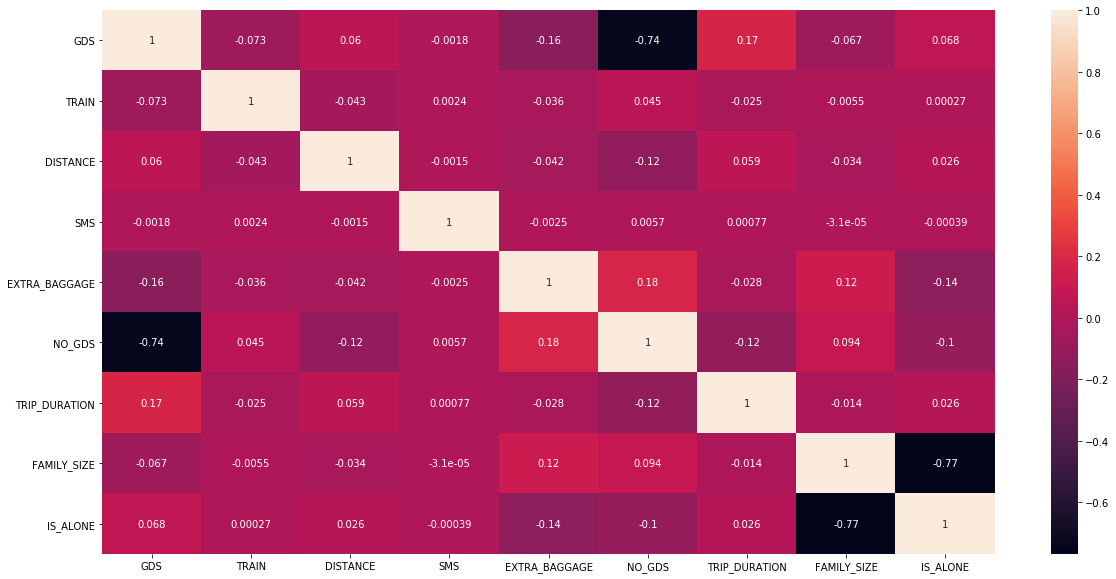

In [20]:
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c,annot=True)
c

From the corralation matrix of numerical and bool data we can see that the last corralated feature with our labels is SMS confirmation and that the most corralated data are NO_GDS and GDS (we can see that they are very high corralated between them) as well as FAMILY_SIZE and IS_ALONE, which are also very corralated between them.


### DATA BALANCING


Data imbalance can be a handicap when training the model and as we can observe it is imbalanced in our problem, where 80% of the bookings did not asked for an EXTRA BAGGAGE and just nearly 20% of them did.

In [32]:
df['EXTRA_BAGGAGE'].value_counts(normalize=True)

False    0.80402
True     0.19598
Name: EXTRA_BAGGAGE, dtype: float64

Let's proceed to balance the data by separating majority and minority for each label class and then, upsampling the minority, which corresponds to the positive labels (we have less cases where users selected EXTRA BAGGAGE).

In [33]:
# Separate majority and minority classes
df_majority = df[df.EXTRA_BAGGAGE==0]
df_minority = df[df.EXTRA_BAGGAGE==1]

print(f'Majority len = {len(df_majority)}')
print(f'Minority len = {len(df_minority)}')

Majority len = 40201
Minority len = 9799


In [34]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=1234) 
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['EXTRA_BAGGAGE'].value_counts()

True     40201
False    40201
Name: EXTRA_BAGGAGE, dtype: int64

In [35]:
df = df_upsampled

### CATEGORICAL DATA

With the categorical data, we can do several things depending in which models we will use. 

* For deep learning models, such as the Neural Network that is developed in the main code, the one option would be to do either one-hot encoding vectors or mean encoding (I have chosen mean-encoding). After that, it is needed to normalize all data and I have done it by [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). 


* For Machine Learning, there are some models which can directly deal with categorical data such as [LightGBM-Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) and some other which would need mean-encoding on categorical data, such as [RandomForest]().


#### OPTION A
So, for the RandomForest model, we can prepare the data by applying mean-encoding. However, it is very important that we just use the information of the training data to encode the data. Then, it can be applied to validation and test set but we can not use the information of those two sets on the encoding procedure, otherwise it would be like cheating and so it would differ the performance of the model in real scenarios.

In [36]:
def mean_encoding(df, col, column_dict=None):
    if column_dict is None:
        column_dict = df.groupby(col).mean()['EXTRA_BAGGAGE'].to_dict()
    df[col] = df[col].apply(column_dict.get)
    return column_dict, df

In [37]:
if not best_results:
    train_df, val_df = train_test_split(df, test_size=0.2)
    # MEAN ENCODING FOR CATEGORICAL VARIABLES
    # With train encoding parameters --> apply to validation and test set
    for col in ['WEBSITE', 'HAUL_TYPE', 'DEVICE', 'TRIP_TYPE', 'PRODUCT']:
        column_dict, train_df = mean_encoding(train_df, col)
        # SUBSTITUTE IN VAL SET
        _, val_df = mean_encoding(val_df, col, column_dict)
        val_df[col].fillna((train_df[col].mean()), inplace=True)
        # SUBSTITUTE IN TEST SET
        #_, df_test = mean_encoding(df_test, col, column_dict)
        #df_test[col].fillna((train_df[col].mean()), inplace=True)

    # CONVERT ALL VALUES TO FLOAT
    train_df = train_df.astype(float)
    assert val_df.isnull().values.any() == False, 'There are NaN values in validation set'
    val_df = val_df.astype(float)
    #df_test = df_test.astype(float)

#### OPTION B

However, for LightGBM models we need to point out in pandas dataframe which are categorical variables in order to ease the model to deal with them correctly. So, we can use the following code:

In [38]:
if best_results:
    df_LGBM = df.copy()
    
    if 'WEB' in df and 'COUNTRY' in df:
        columns = ['WEBSITE', 'HAUL_TYPE', 'DEVICE', 'TRIP_TYPE', 'PRODUCT', 'WEB', 'COUNTRY']
    else:
        columns = ['WEBSITE', 'HAUL_TYPE', 'DEVICE', 'TRIP_TYPE', 'PRODUCT']
        
    for col in columns:
        df_LGBM[col] = df_LGBM[col].astype('category')

    train_df, val_df = train_test_split(df_LGBM, test_size=0.2)

## TRAINING MODEL

Now, independently of the option chosen for treating categorical data, we need to separate the data from the labels for the training and the validation set.

In [39]:
y_train = train_df['EXTRA_BAGGAGE']
X_train = train_df.drop('EXTRA_BAGGAGE', 1)
y_val = val_df['EXTRA_BAGGAGE']
X_val = val_df.drop('EXTRA_BAGGAGE', 1)

In [40]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64321 entries, 24656 to 26645
Data columns (total 13 columns):
WEBSITE          64321 non-null category
GDS              64321 non-null int64
TRAIN            64321 non-null bool
HAUL_TYPE        64321 non-null category
DISTANCE         64321 non-null int64
DEVICE           64321 non-null category
TRIP_TYPE        64321 non-null category
PRODUCT          64321 non-null category
SMS              64321 non-null bool
NO_GDS           64321 non-null int64
TRIP_DURATION    64321 non-null float64
FAMILY_SIZE      64321 non-null float64
IS_ALONE         64321 non-null bool
dtypes: bool(3), category(5), float64(2), int64(3)
memory usage: 3.4 MB


I decide to use LGBMClassifier because from my experience tree ensambles work better for classification and are robust to imbalance data. Besides, this model can work with categorical data without needing to encode it. 

The parameters are optimized by using gridSearch in the github repository. However, in this notebook I put directly the optimized parameters (the ones under best_results condition in the following cell).

In [41]:
if best_results:
    model = lgb.LGBMClassifier(learning_rate=0.05, max_depth=20, n_estimators=300, num_leaves=1000)
else:
    model = lgb.LGBMClassifier() # default parameters

In [42]:
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=20,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Now we define a function to plot the confusion matrix and we proceed to the evaluation.

In [43]:
def plot_confusion_matrix(y_true, y_pred, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        title = 'Normalized confusion matrix'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        title = 'Confusion matrix, without normalization'
        print('Confusion matrix, without normalization')

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)  # annot=True to annotate cells
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['SINGLE', 'EXTRA'])
    ax.yaxis.set_ticklabels(['SINGLE', 'EXTRA'])
    plt.show()

Model Performance
-----------------------------
Error percentage: 10.9 %
F1 score = 89.84%
ROC_AUC = 95.44%
-----------------------------
Normalized confusion matrix


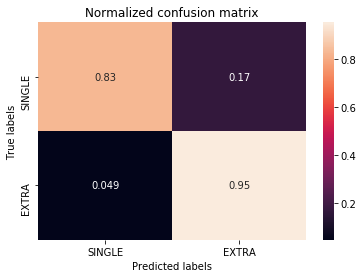

In [44]:
y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)
prob_y_1 = [p[1] for p in y_pred_prob]

y_true = y_val.values

n_errors = len(np.where((y_pred == y_true) == False)[0])
f1 = f1_score(y_true, y_pred)

print('Model Performance')
print('-----------------------------')
print('Error percentage: {:0.1f} %'.format((n_errors/len(y_pred))*100))
print('F1 score = {:0.2f}%'.format(f1*100))
roc = roc_auc_score(y_true, prob_y_1)
print('ROC_AUC = {:0.2f}%'.format(roc*100))
print('-----------------------------')




# Plot normalized confusion matrix
#cm, ax = plot_confusion_matrix(y_true, y_pred, normalize=False)


plot_confusion_matrix(y_true, y_pred, normalize=True)


### CONCLUSIONS 





- BALANCE IMBALANCE 

- TEST LO MATEIX --> AMB EL CODI

'dataset_test'